In [2]:
from ipywidgets import interact
import ipywidgets as widgets
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [3]:
fs, p = wavfile.read('sonido-presion/presion_segmento_1.wav')
fs, y = wavfile.read('sonido-presion/y_segmento_1.wav')
fs, b = wavfile.read('sonido-presion/beta_segmento_1.wav')
fs, s_m = wavfile.read('sonido-presion/sonido_segmento_1.wav')
fs, delta = wavfile.read('sonido-presion/delta1_segmento_1.wav')
fs, delta2 = wavfile.read('sonido-presion/delta2_segmento_1.wav')
fs, k = wavfile.read('sonido-presion/k_segmento_1.wav')
fs, vs = wavfile.read('sonido-presion/vs_segmento_1.wav')

In [4]:
import json
file_fon = open('sonido-presion/t_fon_segmento_1.json') 
t_silabas_file = open('sonido-presion/t_silabas.json') 

# returns JSON object as a list 
t_silabas = json.load(t_silabas_file)['segmento_1']
t_fonacion = json.load(file_fon) 

Este diccionario es importante porque marca los tiempos donde está prendicio delta y k. Así va hacer más fácil encotnrar la relación entre k,delta y vs

In [5]:

dt = 1/fs
N  = len(p)
t = np.arange(0, N) * dt

print(f'frec muestreo: {fs} \n dt muestreo: {dt} \n tiempo total de medición {t[-1]} s')

frec muestreo: 44150 
 dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.8827859569648924 s


In [6]:
print(len(p), len(y), len(b), len(s_m), len(delta))

38976 38976 38976 38976 38976


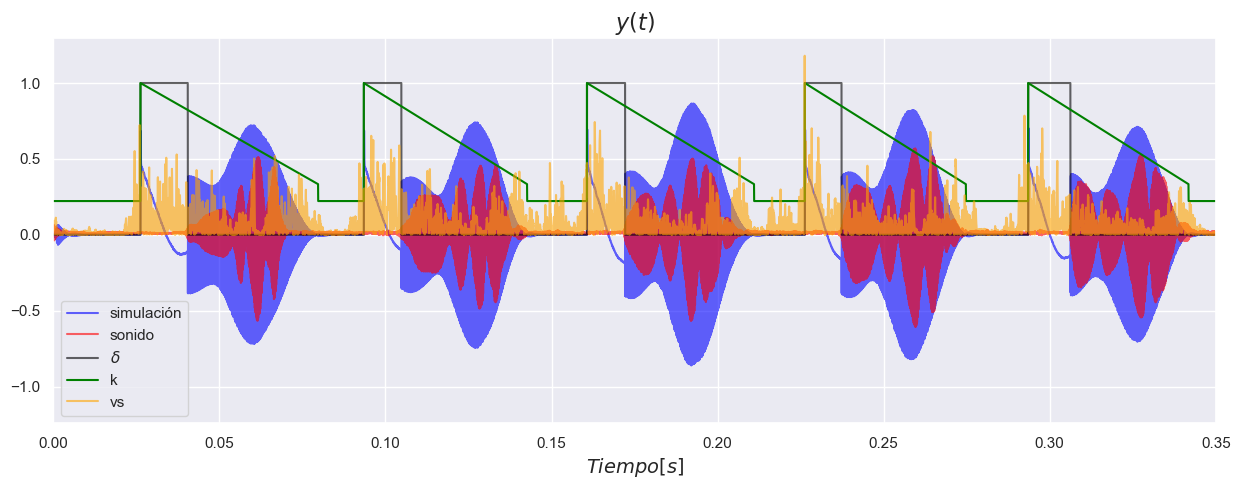

In [7]:
%matplotlib inline
plt.figure( figsize=(15,5))
#ploteo
colors = ['green','red','black','blue']

plt.plot(t, y/max(y),alpha = .60, color=colors[3], label = r'simulación')
plt.plot(t, s_m/max(s_m) ,alpha = .60, color='red', label = r'sonido')
#plt.plot(t, b, alpha = .60, color=colors[1], label = r'$\beta$')
plt.plot(t, delta, alpha = .60, color=colors[2], label = r'$\delta$')
plt.plot(t, k/max(k), color = 'green', label = 'k')
plt.plot(t, np.abs(vs)/max(vs), alpha = .6, color = 'orange', label = 'vs')
#plt.plot(t, (delta_interp  + ruido) * f0, alpha = .6, color = colors[2], label = r'$\delta$')
plt.legend(loc=0)
plt.xlim(0,0.35)
plt.xlabel('$Tiempo [s]$', fontsize=14)
plt.title(r'$y(t)$', fontsize=16)
plt.show()

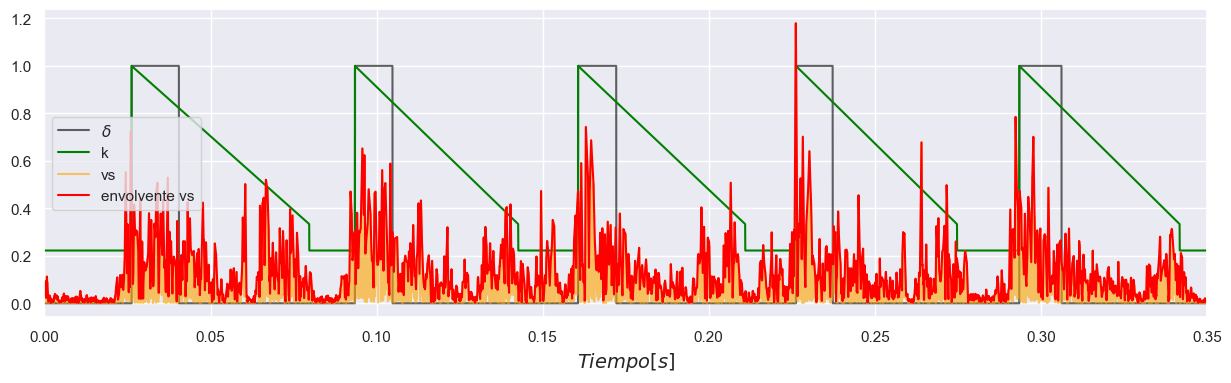

In [8]:
picos_vs, _ = signal.find_peaks(np.abs(vs), height = 0 )  

plt.figure( figsize=(15,4))
#ploteo
colors = ['green','red','black','blue']

plt.plot(t, delta, alpha = .60, color=colors[2], label = r'$\delta$')
plt.plot(t, k/max(k), color = 'green', label = 'k')
plt.plot(t, abs(vs)/max(vs), alpha = .6, color = 'orange', label = 'vs')
plt.plot(t[picos_vs], np.abs(vs[picos_vs])/max(vs), color = 'red', label = 'envolvente vs')
plt.legend(loc=0)
plt.xlim(0,0.35)
plt.xlabel('$Tiempo [s]$', fontsize=14)
#plt.title(r'$y(t)$', fontsize=16)
plt.show()

### Corro la simulación para distintos valores de k


In [9]:

#funcion del sistema de ecuaciones
def f(X, t, params):
    w, x = X
    k, c, delta, beta = params

    gamma = 1e4*2 #reescaleo
    mu = 1e5

    f_w = -gamma * k / mu * (x + delta / k)
    f_x = gamma * mu * (w - c * x**3 / mu + beta * x / mu )
    return np.array([f_w,f_x])

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X

from scipy.fft import fft, fftfreq

def get_principal_frequency(signal, fs):
    N = len(signal)
    
    # Apply a window to reduce spectral leakage (optional but recommended)
    window = np.hanning(N)
    signal_windowed = signal * window

    # Compute FFT and frequencies
    yf = fft(signal_windowed)
    xf = fftfreq(N, 1 / fs)

    # Only take the positive half of spectrum
    idx = np.where(xf >= 0)
    xf = xf[idx]
    yf = np.abs(yf[idx])

    # Find the frequency with the maximum magnitude
    dominant_freq = xf[np.argmax(yf)]

    return dominant_freq

def y(w,x, beta):
    mu = 1e5
    return w - mu * (x**3/3 - beta * x )

In [10]:
# condiciones iniciales
x0 = 0.01
w0 = 0
X0 = np.array([w0, x0])

#parametros
ks =  np.linspace( 1, 5, 15)
f0 = 5
c = 1

In [11]:
ks

array([1.        , 1.28571429, 1.57142857, 1.85714286, 2.14285714,
       2.42857143, 2.71428571, 3.        , 3.28571429, 3.57142857,
       3.85714286, 4.14285714, 4.42857143, 4.71428571, 5.        ])

In [12]:
#pasos temporales de la simulacion
dt_s = 1 / (fs * 20)
fs_s = 1/dt_s
t_s = np.arange(0, t[-1] + dt, dt_s)

In [13]:
#inrepolo p

interp_func = interp1d(t, p)

b_interpolado = interp_func(np.linspace(0, t[-1],len(t_s) ))

#interpolo delta
interp_func2 = interp1d(t, delta2)

delta_interp = interp_func2(np.linspace(0, t[-1],len(t_s) ))

In [14]:
# normalizo y offset de beta
offset = 0.3
b_ = (b_interpolado/max(b_interpolado)) + offset 

#sumo ruido
sigma_s = np.std(s_m[(p + offset)<0]/max(s_m))
ruido = np.random.normal(0, sigma_s, len(t_s))

N_i = len(t_s)


In [15]:
frecs_ppales = []

for i, k_ in enumerate(ks):
    #condiciones iniciales 
    Xs = np.zeros((N_i + 1, 2))
    Xs[0] = X0
    #integro
    for j in range(N_i):
        params = [k_, c, f0 * ruido[j], b_[j]]
        #params = [k_, c, 1, b_[j]]
        Xs[j + 1] = paso_RK(Xs[j], f, t_s[j], dt_s, params, 4)

   # print(len(Xs[:,0]), len(Xs[:,1]), len(b_))
    y_ = y(Xs[:,0][:-1], Xs[:,1][:-1], b_)
    frec_ppal = get_principal_frequency(y_, fs)
    print(f'Frecuencia principal: {frec_ppal} Hz')
    frecs_ppales.append( frec_ppal)


Frecuencia principal: 155.69626180213467 Hz
Frecuencia principal: 173.25386135057474 Hz
Frecuencia principal: 192.623858271757 Hz
Frecuencia principal: 209.33189655172416 Hz
Frecuencia principal: 230.28774117405584 Hz
Frecuencia principal: 241.5585873357964 Hz
Frecuencia principal: 256.45422824302136 Hz
Frecuencia principal: 270.1604833743843 Hz
Frecuencia principal: 283.3570017446634 Hz
Frecuencia principal: 295.76059626436785 Hz
Frecuencia principal: 309.6934010673235 Hz
Frecuencia principal: 321.07752206486043 Hz
Frecuencia principal: 331.6120817939245 Hz
Frecuencia principal: 342.882927955665 Hz
Frecuencia principal: 352.9077509236453 Hz


Coeficiente del ajuste lineal: [ 48.92127768 117.68004696]


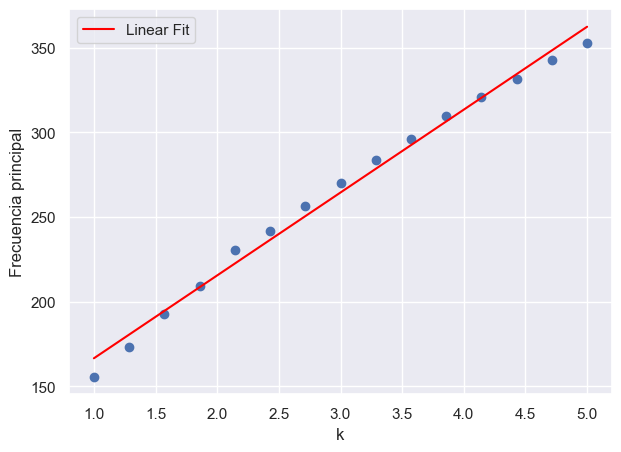

In [105]:

#ajuste lineal
coefficients = np.polyfit(ks, frecs_ppales, 1)
print("Coeficiente del ajuste lineal:", coefficients)

# creo la funcion polinomica
poli = np.poly1d(coefficients)

plt.figure(figsize = (7,5))
plt.plot(ks,frecs_ppales,'o')
plt.plot(ks, ks * coefficients[0] + coefficients[1], label='Linear Fit', color='red')
plt.xlabel('k')
plt.ylabel('Frecuencia principal')
plt.legend()
plt.show()

In [106]:
a1, a2 = coefficients

print(f'La función es omega(k) = {a1} k + {a2}')
print(f' La funcinó inversa es k(omega) =  {(1/a1)} omega - {a2/a1}')

La función es omega(k) = 48.921277677288614 k + 117.68004696266073
 La funcinó inversa es k(omega) =  0.02044100333185377 omega - 2.405498232056456


In [17]:
def k_w(w):
    m, b = coefficients
    return (1/m)* w - b/m

#### Espectrograma

El paso a seguir es hallar las frecuencias principales en función del tiempo para las diferentes silabas donde hay sonido.
Para eso lo que voy a hacer es barrer con el espectrograma cada silaba y hallar las frecuencias principales de 5 tiempos por silaba y guardarlos en un diccionario.

In [18]:
def get_spectrogram(data, sampling_rate, window=1024, overlap=1/1.1,
                    sigma=102.4, fmax=8000, drange=6):
    fu, tu, Sxx = signal.spectrogram(data, sampling_rate, nperseg=window,
                                     noverlap=window*overlap,
                                     window=signal.get_window
                                     (('gaussian', sigma), window),
                                     scaling='spectrum')
    Sxx = np.clip(Sxx, a_min=np.amax(Sxx)/10**drange, a_max=np.amax(Sxx))
    return fu, tu, Sxx

In [19]:
#espextrograma del sonido
fu, tu, Sxx = get_spectrogram(s_m, fs)
Sxx = np.clip(Sxx, a_min=np.amax(Sxx)/20000000, a_max = np.amax(Sxx))

import matplotlib.colors as mcolors
colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=5)

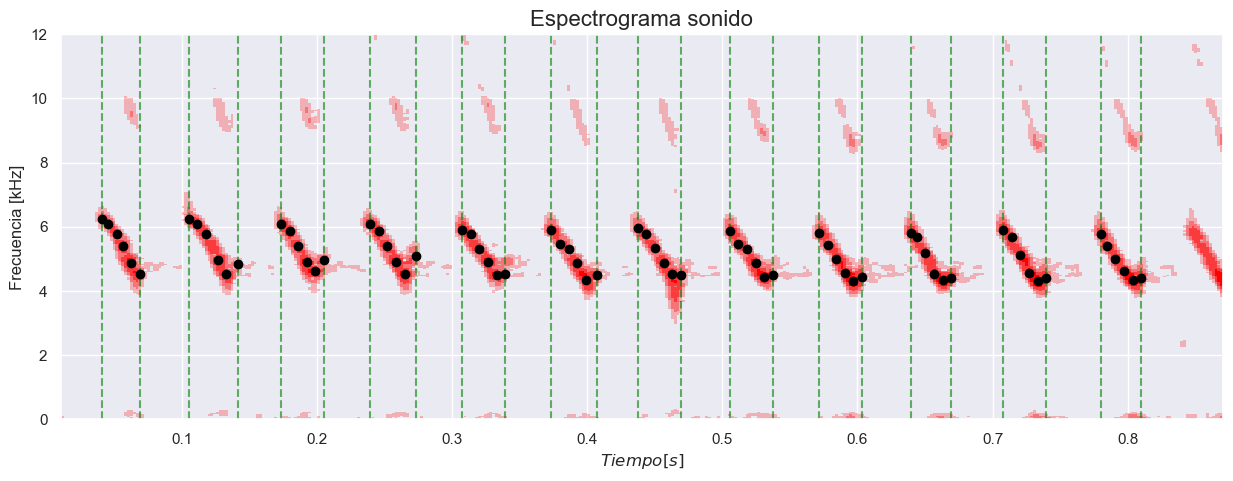

In [139]:

#ploteo espectrograma
plt.figure(figsize = (15,5))
#plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred, label = 'simulacion')
plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred, label = 'sonido')

# construyo un diccionario para guardar las frecuencias principales de cada silaba
frecs_p = {sil : {'t': [], 'fp': []} for sil in t_silabas}


for sil in t_silabas:
    #tiempo inicial de silabas
    ti = t_silabas[sil]['t_i']
    tf = t_silabas[sil]['t_f']
    tu_i = tu[ ti < tu][0] #elijo que sea un punto de la tira de tu
    tu_f = tu[ tf < tu][0]

    #fonacion
    #tiempos de fonacioon
    tfon = tu[(tu >= t_fonacion[sil]['t_i']) & (tu <= t_fonacion[sil]['t_f'])] #agarro toda la tira de tu fonacion
    #print(len(tfon))
    
    indices = np.linspace(0, len(tfon) - 1, 6, dtype=int) # agarro 5 elementos, que van a ser los que use para buscar la fp y hacer el ajuste (NO AGARRO LOS DEL FINAL)
    tu_fon = tfon[indices]
    #frecuencias principales
    fps = []
    for tu_ in tu_fon:
        index = np.where(tu_ == tu)
        frec_p = fu[np.argmax(Sxx[:,index])] #frecuencia principal de ese tiempo tu[index]
        fps.append(frec_p)

    #guardo en el diccionario
    frecs_p[sil]['t'] = tu_fon
    frecs_p[sil]['fp'] = np.array(fps)

    #print(tu_i, tu_f)
    #plt.axvline(tu_i, ls = '--', color = 'blue', alpha = .6)
    #plt.axvline(tu_f,ls = '--', color = 'blue', alpha = .6)

    plt.axvline(tfon[0], ls = '--', color = 'green', alpha = .6)
    plt.axvline(tfon[-1],ls = '--', color = 'green', alpha = .6)
    plt.plot(tu_fon, np.array(fps)/1e3,'o', color = 'black')
plt.ylim(0,12)
plt.xlabel('$Tiempo [s]$')
plt.ylabel('Frecuencia [kHz]')
plt.title(r'Espectrograma sonido', fontsize=16)

plt.show()

### Envolvente
En esta sección prosigo hallando los valores de la envolvente de vs en los tiempos de la secciòn anterior (donde calculamos las frecuencias principales)

Hallo la envolvente, utilizo un factor $\tau$ independiente del que obtuve en $\delta$:
#### Integro: Cálculo de la envolvente g(EMG)

$$
\dot{g} = \frac{1}{\tau} (-g + vs(t))
$$


In [22]:
#funcion del sistema de ecuaciones
def f(x, t, params):

    tau, vs = params

    f_x = 1/tau * (-x + vs)
    return f_x

#método Runge-Kutta 4
def paso_RK(X, f, t, dt, params, orden=4):
    k1 = f(X, t, params)
    k2 = f(X + k1 * dt / 2, t, params)

    if orden == 2:
        X = X + (k1 + k2) / 2 * dt
    elif orden == 4:
        k3 = f(X + k2 * dt / 2, t, params)
        k4 = f(X + k3 * dt, t, params)
        X = X + (k1 + 2 * (k2 + k3) + k4) / 6 * dt
    return X


In [68]:
tau = 1.5 * 1e-2 # es un tau razonable? no enceuntro un criterio cuantitativo. charlarlo con Gabo
#condiciones iniciales
x0 = np.abs(vs[0])
env = np.zeros(N)
env[0] = x0

for j in range(N-1):
    #print(j)
    params = [tau, np.abs(vs[j])]
    paso = paso_RK(env[j], f, t[j], dt, params, 4)
    env[j + 1] = paso

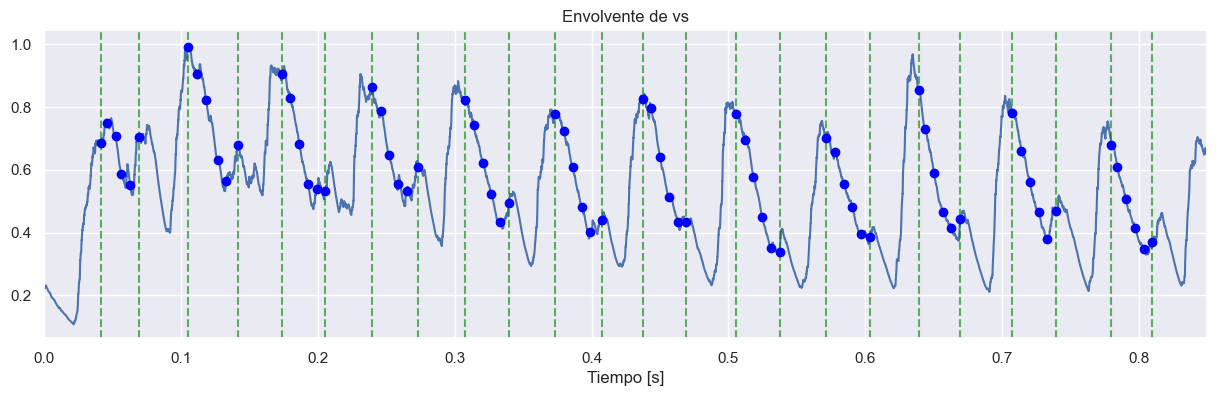

In [152]:

plt.figure(figsize = (15,4))
plt.title('Envolvente de vs')
plt.plot(t,env/max(env), label = 'envolvente(vs)')
for sil in t_silabas:
    #tiempo inicial de silabas
    ti = t_silabas[sil]['t_i']
    tf = t_silabas[sil]['t_f']
    tu_i = tu[ ti < tu][0] #elijo que sea un punto de la tira de tu
    tu_f = tu[ tf < tu][0]

    #fonacion
    #tiempos de fonacioon
    tfon = tu[(tu >= t_fonacion[sil]['t_i']) & (tu <= t_fonacion[sil]['t_f'])] #agarro toda la tira de tu fonacion
    plt.axvline(tfon[0], ls = '--', color = 'green', alpha = .6)
    plt.axvline(tfon[-1],ls = '--', color = 'green', alpha = .6)
    plt.plot(frecs_p[sil]['t'], frecs_p[sil]['vs']/max(env), 'o', color = 'blue')
    #print(len(tfon))
#plt.plot(t,np.abs(vs)/max(vs), label = 'vs')
#plt.plot(frecs_p[sil]['t'], frecs_p[sil]['vs']/1e3, 'o', color = 'blue')
plt.xlim(0,0.85)
#plt.legend()
plt.xlabel('Tiempo [s]')
plt.show()

In [142]:
#frecs_p = {sil : {'t': [], 'fp': []} for sil in t_silabas}

for i, sil in enumerate(frecs_p):
    frecs_p[sil]['vs'] = []
    for ti in frecs_p[sil]['t']:
        index = np.where(t >= ti)[0][0]
        vs_i = env[index]
        frecs_p[sil]['vs'].append(vs_i)
    frecs_p[sil]['vs'] = np.array(frecs_p[sil]['vs'])

C:\Users\Luna\AppData\Local\Temp\ipykernel_5456\490162658.py:16: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


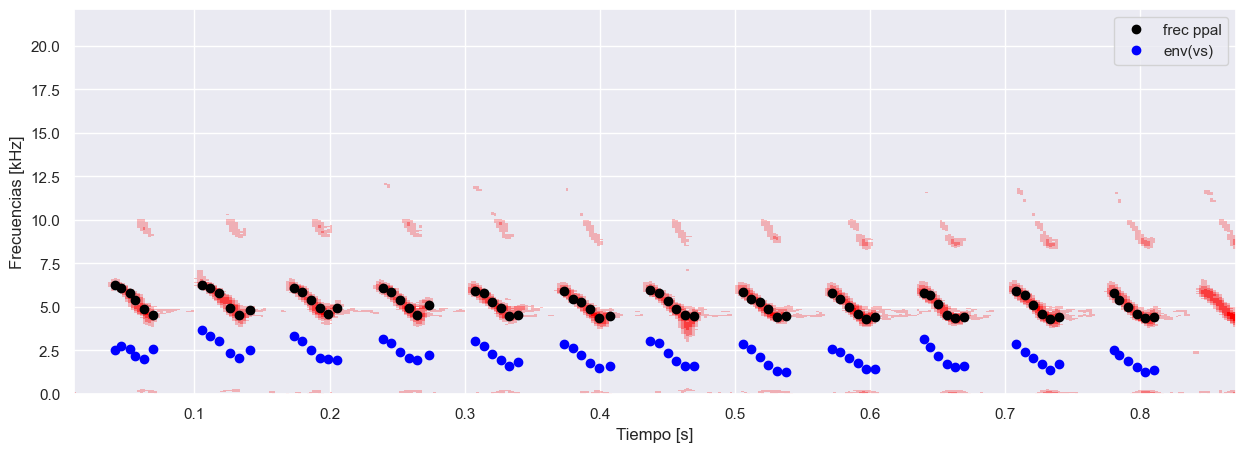

In [71]:
#ploteo espectrograma
plt.figure(figsize = (15,5))
#plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred, label = 'simulacion')
plt.pcolormesh(tu, fu/1000, np.log(Sxx), rasterized=True, shading='auto', cmap=cmapred, label = 'sonido')

for i, sil in enumerate(frecs_p):
    if i == 0:
        plt.plot(frecs_p[sil]['t'], frecs_p[sil]['fp']/1e3, 'o', color = 'black', label = 'frec ppal')
        plt.plot(frecs_p[sil]['t'], frecs_p[sil]['vs']/1e3, 'o', color = 'blue', label = 'env(vs)')
    else:
        plt.plot(frecs_p[sil]['t'], frecs_p[sil]['fp']/1e3, 'o', color = 'black')
        plt.plot(frecs_p[sil]['t'], frecs_p[sil]['vs']/1e3, 'o', color = 'blue')

plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencias [kHz]')
plt.legend()
plt.show()

Coeficiente del ajuste lineal: [ 48.92127768 117.68004696]


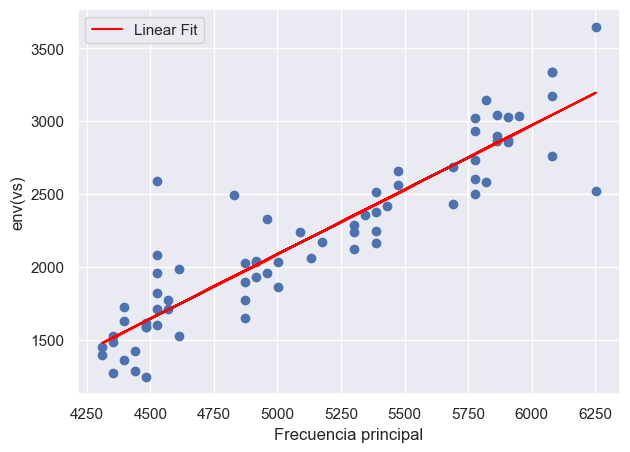

In [107]:
fps = np.array([frecs_p[sil]['fp'] for sil in frecs_p]).reshape(1,72)[0]
vs_env = np.array([frecs_p[sil]['vs'] for sil in frecs_p]).reshape(1,72)[0]
#print(fps)
#ajuste lineal
coefficients2 = np.polyfit(fps, vs_env, 1)
print("Coeficiente del ajuste lineal:", coefficients)

# creo la funcion polinomica
poli = np.poly1d(coefficients2)

plt.figure(figsize = (7,5))
plt.plot(fps, vs_env,'o')
plt.plot(fps, poli(fps), label='Linear Fit', color='red')
plt.ylabel('env(vs)')
plt.xlabel('Frecuencia principal')
plt.legend()
plt.show()




plt.show()

### Obtenemos k(env)

Teníamos de los dos ajustes que hicimos:
$$
\begin{cases}
k(\omega) = a_1 \omega + a_2  \\
\omega(env) = b_1 env + b_2
\end{cases} 
\Longrightarrow k(env) =  a_1 \omega(env) + a_2 = a_1 (b_1 env + b_2) + a_2 = a_1 b_1 env + a_1 b_2 + a_2
$$

In [111]:
a1, a2 = coefficients # coeficientes del ajuste lineal: w(k)
a_1, a_2 = (1/a1) , (a2/a1) # coeficiente de la funcion inversa: k(w)

print(f'La función es omega(k) = {a1} k + {a2}')
print(f' La funcinó inversa es k(omega) =  {a_1} omega - {a_2}')

La función es omega(k) = 48.921277677288614 k + 117.68004696266073
 La funcinó inversa es k(omega) =  0.02044100333185377 omega - 2.405498232056456


In [112]:
b1, b2 = coefficients2 # coeficientes del ajuste lineal: env(w)
b_1, b_2 = (1/b1) , (b2/b1) # coeficiente de la funcion inversa: w(env)

print(f'La función es env(omega) = {b1} omega + {b2}')
print(f' La funcinó inversa es omega(env) =  {b_1} env - {b_2}')

La función es env(omega) = 0.8834913078495297 omega + -2328.8259168979625
 La funcinó inversa es omega(env) =  1.1318730485691584 env - -2635.9352901461625


In [113]:
print(f' La función k(env) =  {a_1 * b_1} env + {a_1 + b_2 + a_2}')

 La función k(env) =  0.02313662075703765 env + -2633.509350910774


In [114]:
def k_env(env):
    return a_1 * b_1 * env + a_1 * b_2 + a_2

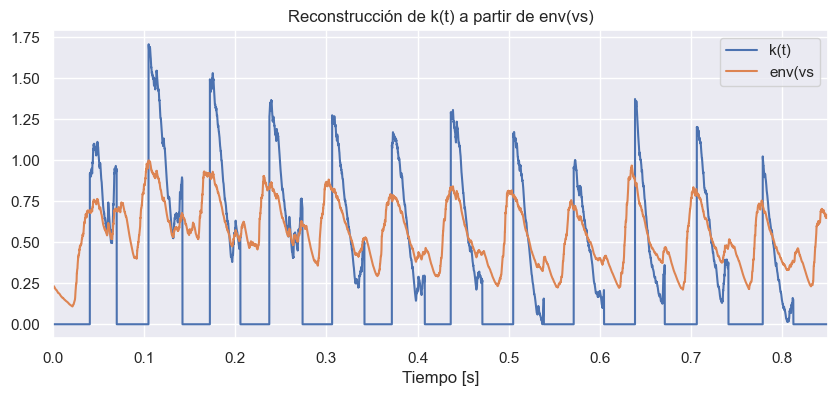

In [158]:
#construyo k(t) a partir de los datos de vs

k_t = np.zeros(len(t))


for sil in t_fonacion:
    ti = t_fonacion[sil]['t_i']
    tf = t_fonacion[sil]['t_f']

    env_ =  np.abs(env[(t >= ti ) & (t <= tf )])

    k_t[(t >= ti ) & (t <= tf )] = k_env(env_)

k_t[k_t==0] = min(k_t)
plt.figure(figsize=(10,4))
plt.plot(t,k_t/max(k_t) - min(k_t/max(k_t)) , label = 'k(t)')
#plt.plot(t,np.abs(k_t)/max(k_t), label = 'k(t) abs')
plt.plot(t,env/max(env), label = 'env(vs')
plt.xlabel('Tiempo [s]')
plt.xlim(0,0.85)
plt.title('Reconstrucción de k(t) a partir de env(vs)')
plt.legend()
plt.show()

In [137]:
#guardo el k(t)
wavfile.write("sonido-presion/k_t_segmento_1.wav", fs, k_t.astype(np.float32))

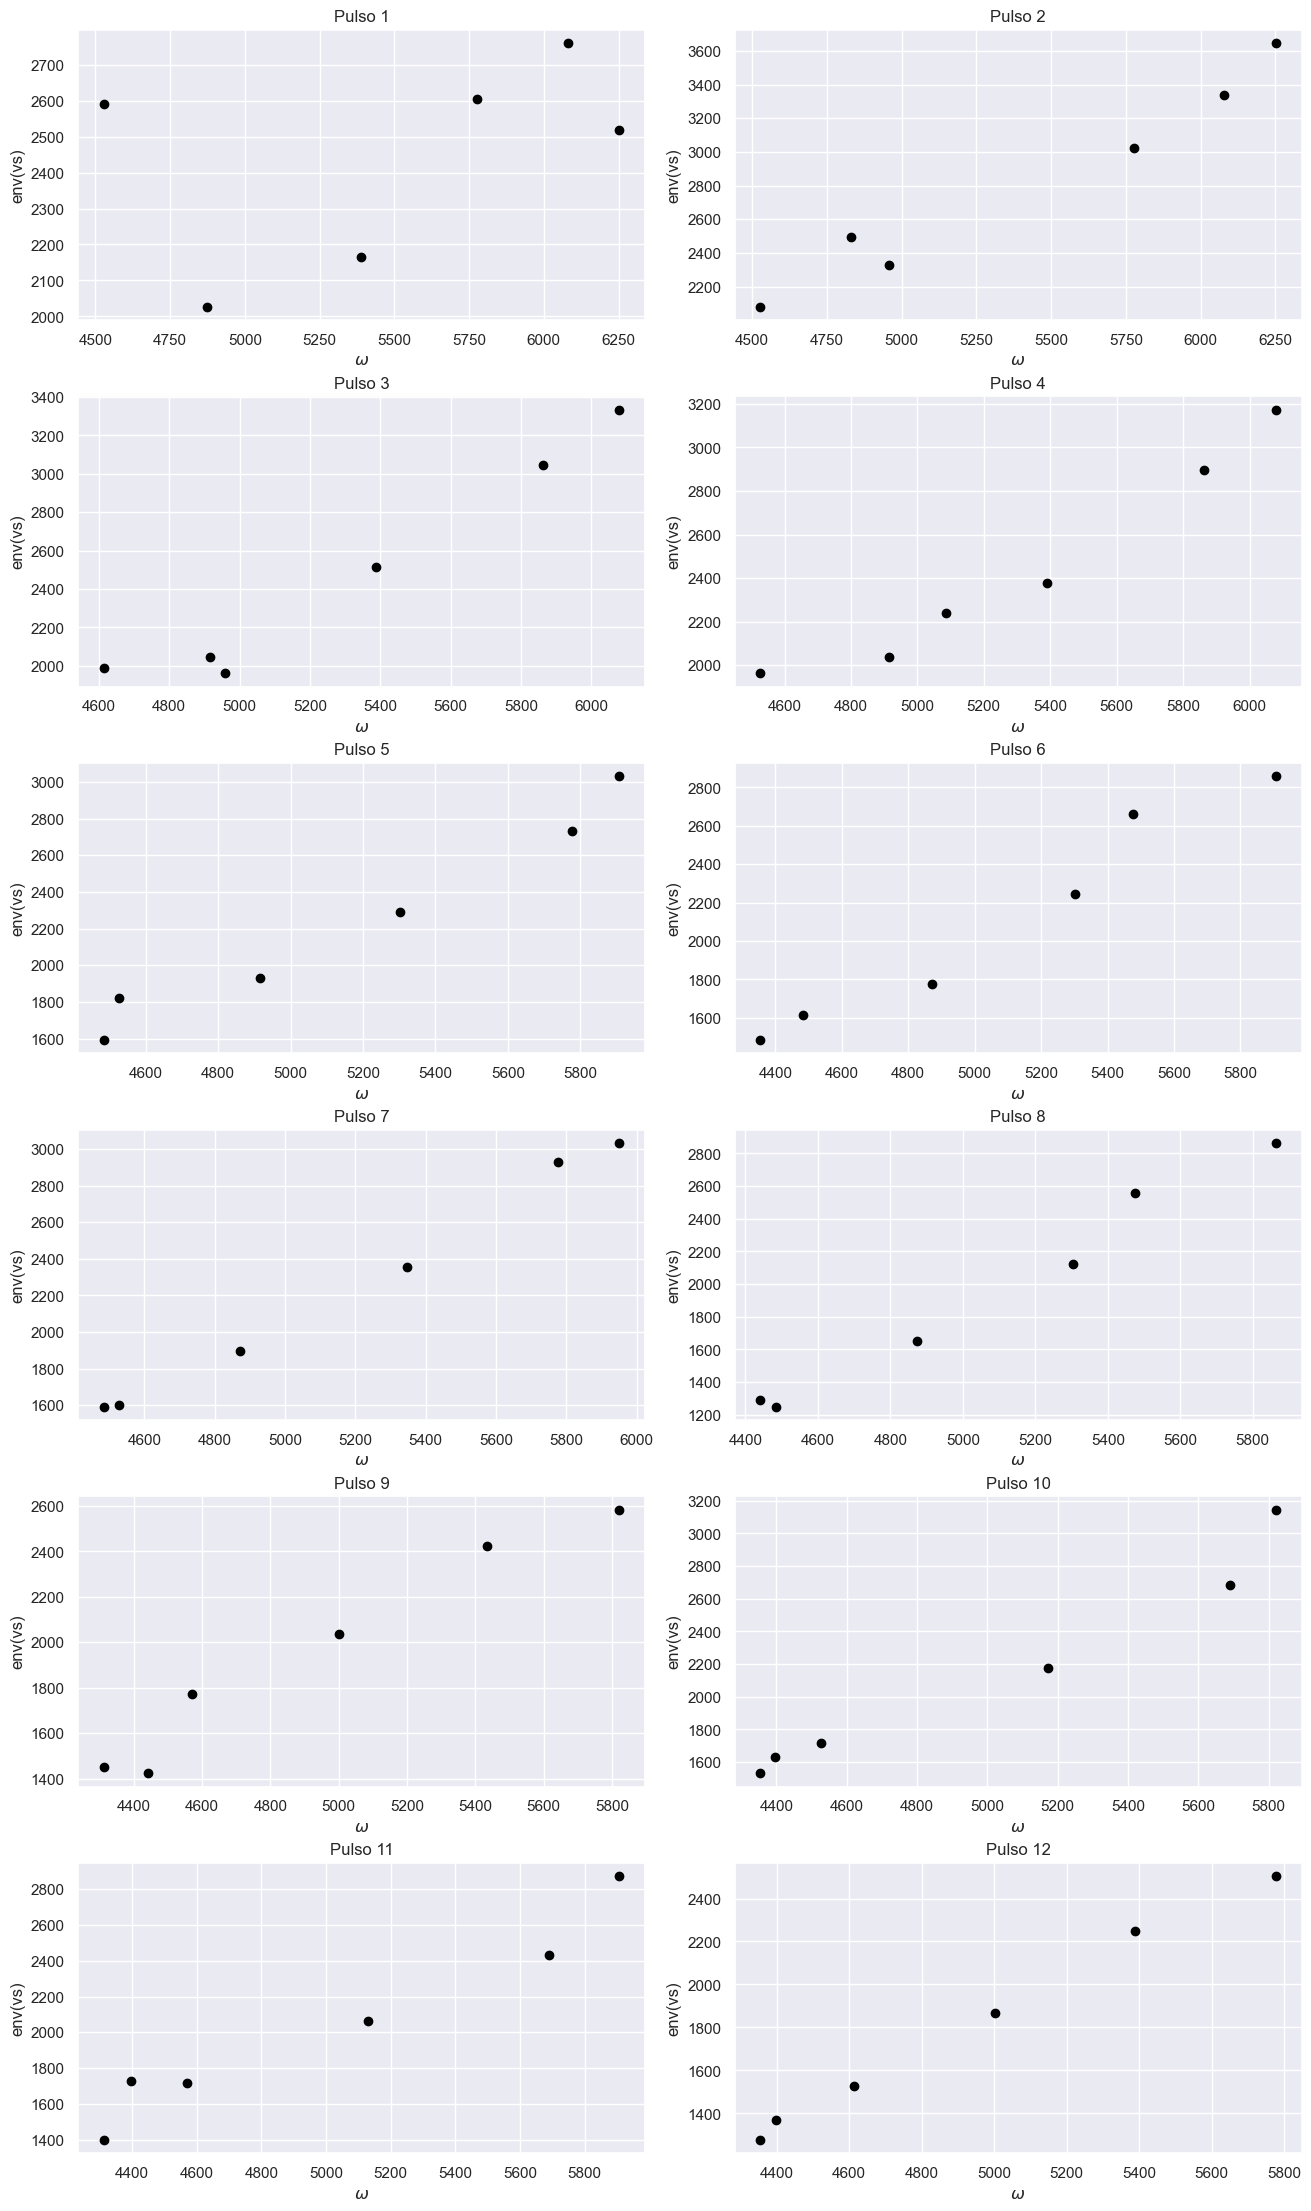

In [73]:
%matplotlib inline
fig, axes = plt.subplots(6, 2, figsize=(13,22), constrained_layout=True, sharey=False)
axs = axes.flatten()

for i,sil in enumerate(frecs_p):

    #print(f'Medición: {fon_m * 100}%')
    axs[i].plot(frecs_p[sil]['fp'], frecs_p[sil]['vs'], 'o', color = 'black')
    axs[i].set_xlabel(r'$\omega$')
    axs[i].set_ylabel(r'env(vs)')
    axs[i].set_title(f'Pulso {i+1}')
    #axs[i].legend()
plt.show()

In [ ]:
cmap_[0]